# **Importing Libraries**

In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import argparse
import os

from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Reading Data**

In [2]:
train_data = image_dataset_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[224,224],batch_size=64,
                                       shuffle=True)
test_data = image_dataset_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[224,224],batch_size=64,
                                       shuffle=True)
valid_data = image_dataset_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/',labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[224,224],batch_size=64,
                                       shuffle=True)

Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


# **Creating Dataset**

In [3]:
#Normalizing by rescaling image to values between 0 & 1
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 45, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [4]:
train_gen = train_datagen.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train',
                                              target_size = (224,224), batch_size = 64, 
                                              class_mode = 'categorical',  color_mode= 'rgb')
val_gen = train_datagen.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation', 
                                            target_size=(224,224), class_mode='categorical', color_mode= 'rgb',
                                            batch_size= 64)
test_gen = test_datagen.flow_from_directory('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test',
                                            target_size = (224,224), class_mode = 'categorical',color_mode= 'rgb',
                                            batch_size = 64)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


# **Data Visualization**
Best practice

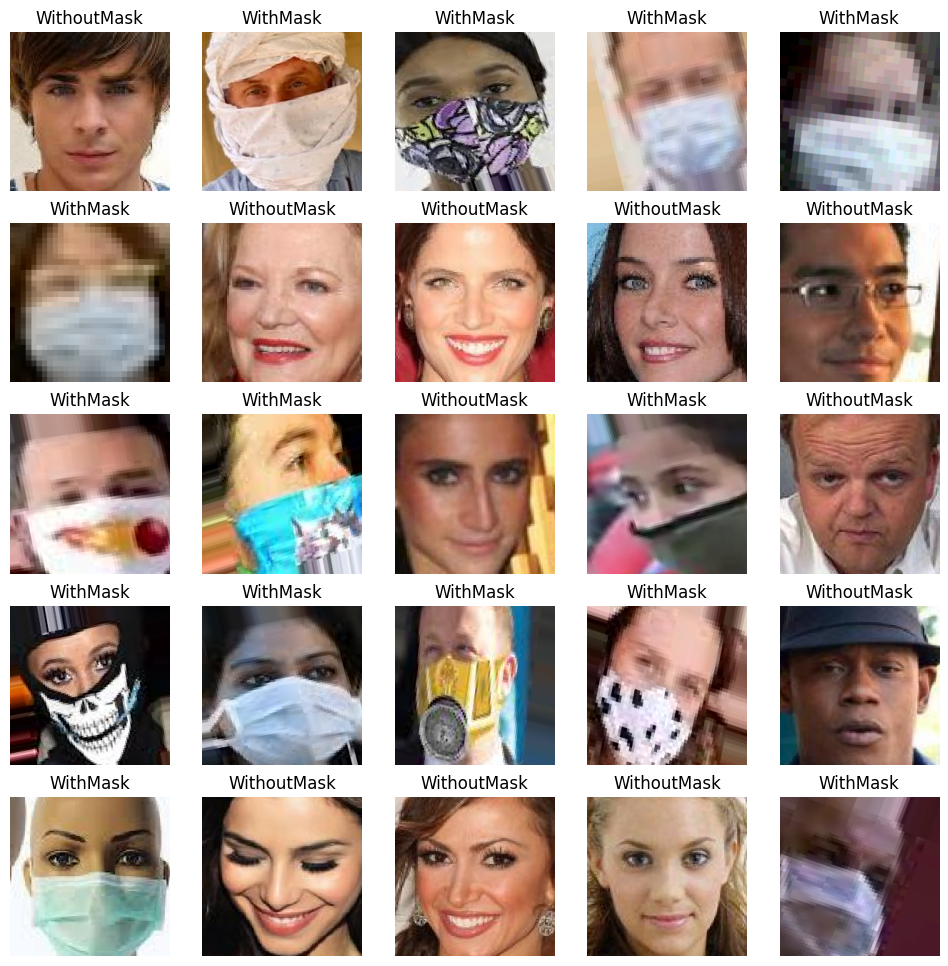

In [5]:
classes_train = train_data.class_names
plt.figure(figsize=(12,12))
for img, label in train_data.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')

# **Model**
### **Transfer Learning flow** 
1. Choosing and initializing a pretrained model with ImageNet weights. 
2. Removing the top or classification head from the pretrained model and freezing the remaining layers so that we don't touch the learned weights.
3. Creating the new model and add new trainable fully connected/dense layers on top of the primary model. You can also add other type of layers such as dropout for regularization
4. Defining the loss function and optimization algorithm and training the new model.
5. Evaluating and improving(or finetuning) the new model.

**Note:** The pretrained model is usually referred to as a primary or base model.

# **Building Model Architecture**

In [6]:
baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

In [7]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(128,activation="relu")(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)
#2 with_mask, without_mask

In [8]:
model=Model(inputs=baseModel.input,outputs=headModel)

In [9]:
for layer in baseModel.layers:
    layer.trainable=False

In [10]:
#Compile Model

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

# **Visualizing Model**

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

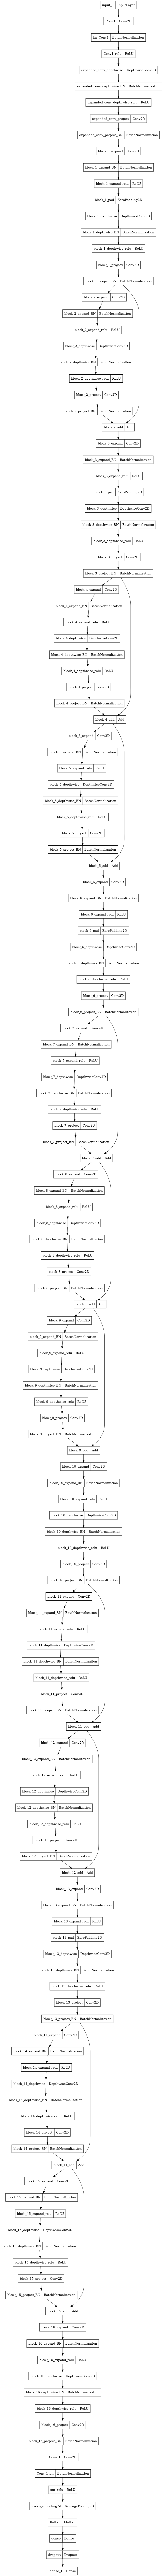

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# **Training Model**

In [13]:
#To prevent Overfitting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2,restore_best_weights=True, verbose=1)
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/20
157/157 [==============================] - 151s 921ms/step - loss: 0.7530 - accuracy: 0.6269 - val_loss: 0.3947 - val_accuracy: 0.8413
Epoch 2/20
157/157 [==============================] - 143s 913ms/step - loss: 0.4849 - accuracy: 0.7738 - val_loss: 0.2739 - val_accuracy: 0.9050
Epoch 3/20
157/157 [==============================] - 143s 909ms/step - loss: 0.3541 - accuracy: 0.8468 - val_loss: 0.2242 - val_accuracy: 0.9262
Epoch 4/20
157/157 [==============================] - 141s 898ms/step - loss: 0.2877 - accuracy: 0.8852 - val_loss: 0.1974 - val_accuracy: 0.9388
Epoch 5/20
157/157 [==============================] - 142s 903ms/step - loss: 0.2464 - accuracy: 0.9018 - val_loss: 0.1601 - val_accuracy: 0.9500
Epoch 6/20
157/157 [==============================] - 143s 914ms/step - loss: 0.2229 - accuracy: 0.9129 - val_loss: 0.1473 - val_accuracy: 0.9513
Epoch 7/20
157/157 [==============================] - 143s 909ms/step - loss: 0.2020 - accuracy: 0.9235 - val_loss: 0.1334 -

# **Plotting Loss & Accuracy**

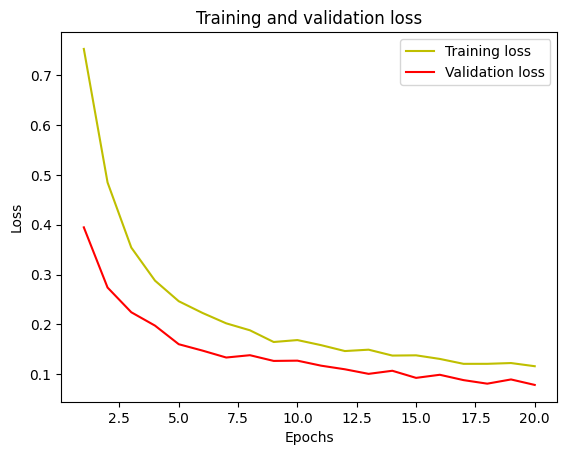

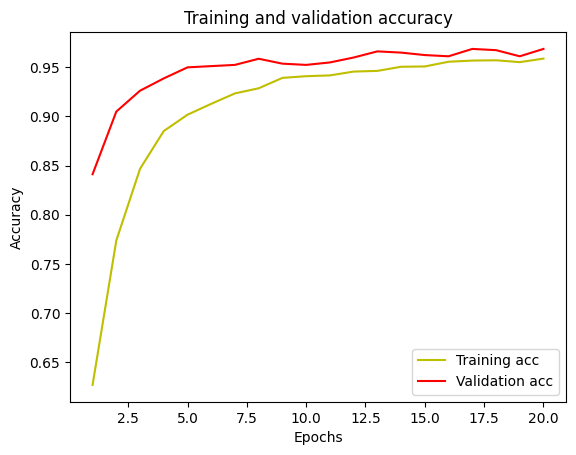

In [14]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Evaluating**

In [15]:
results = model.evaluate(test_gen, verbose=0)
print("Test Loss: "+str(results[0]))
print("Test Accuracy: "+str(results[1]))

Test Loss: 0.061165887862443924
Test Accuracy: 0.9868951439857483


In [16]:
# Predict the label of the test_images
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

16/16 [==============================] - 5s 240ms/step


In [17]:
from pathlib import Path
import os
import glob 
import pandas as pd

image_dir = Path('../input/face-mask-12k-images-dataset/Face Mask Dataset/Test')

filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,../input/face-mask-12k-images-dataset/Face Mas...,WithMask
1,../input/face-mask-12k-images-dataset/Face Mas...,WithMask
2,../input/face-mask-12k-images-dataset/Face Mas...,WithMask


In [18]:
#Report
from sklearn.metrics import classification_report
y_test = list(image_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    WithMask       0.52      0.52      0.52       483
 WithoutMask       0.54      0.54      0.54       509

    accuracy                           0.53       992
   macro avg       0.53      0.53      0.53       992
weighted avg       0.53      0.53      0.53       992



# **Saving Model**

In [19]:
#Save Model
model.save("mask_mobileNetV2_detector.model", save_format="h5")